In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import os
import datetime
import itertools

# ログ出力用の関数
def printTime(tag):
    print(tag + ':', datetime.datetime.now())

printTime('Inputファイルを表示')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Inputファイルを表示: 2020-01-27 05:54:36.414422
/kaggle/input/test.csv
/kaggle/input/data_description.txt
/kaggle/input/train.csv
/kaggle/input/.ipynb_checkpoints/train-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/test-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/data_description-checkpoint.txt


#### 学習データの読み込み

In [146]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['SalePrice'], axis=1)
train_y = train['SalePrice']

# テストデータは特徴量のみなので、そのままでよい
test_x = test.copy()

#### 学習データの分析

In [147]:
# SalePriceの平均や標準偏差、最大値、最小値、最頻値などの要約統計量を表示
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

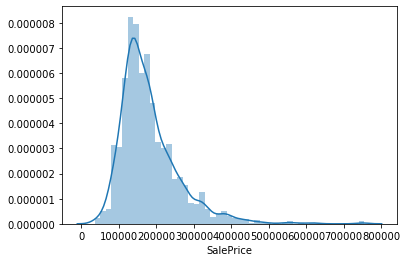

In [148]:
# SalePriceのヒストグラムを表示
sns.distplot(train['SalePrice'])

 #### 特徴量作成
 ##### 課題
 * カテゴリ列の中で、テストデータにしかない値があるとエラーしてしまう。
 * どのカテゴリ列をモデルに与えたらいいのか判断がつかない。

In [149]:
# 解析対象とする数値列を設定
targets_num = ['1stFlrSF', 
               'BsmtFinSF1', 
               'Fireplaces', 
               'FullBath', 
               'GarageArea', 
               'GarageCars', 
               'GarageYrBlt', 
               'GrLivArea', 
               'MasVnrArea', 
               'OverallQual', 
               'TotalBsmtSF', 
               'TotRmsAbvGrd', 
               'YearBuilt', 
               'YearRemodAdd']

# 解析対象とするカテゴリ列を設定
targets_category = [
                    #'MSSubClass',
                    #'MSZoning',
                    'Street',
                    'Alley',
                    'LotShape',
                    'LandContour',
                    #'Utilities',
                    'LotConfig'
                    'LandSlope',
                    'Neighborhood',
                    'Condition1',
                    'Condition2',
                    'BldgType',
                    'HouseStyle',
                    'RoofStyle',
                    'RoofMatl',
                    #'Exterior1st',
                    #'Exterior2nd',
                    'MasVnrType',
                    'ExterQual',
                    'ExterCond',
                    'Foundation',
                    'BsmtQual',
                    'BsmtCond',
                    'BsmtExposure',
                    'BsmtFinType1',
                    'BsmtFinType2',
                    'Heating',
                    'HeatingQC',
                    'CentralAir',
                    'Electrical',
                    #'KitchenQual',
                    #'Functional',
                    'FireplaceQu',
                    'GarageType',
                    'GarageFinish',
                    'GarageQual',
                    'GarageCond',
                    'PavedDrive',
                    'PoolQC',
                    'Fence',
                    'MiscFeature',
                    #'SaleType',
                    'SaleCondition']

targets = targets_num
targets.extend(targets_category)

# 解析対象列のみを抽出
train_x = train_x.loc[:,targets]
test_x = test_x.loc[:,targets]

# Dataframeの列の型がobjectのままだとLabelEncoderでエラーするため、strに変換
# ※変換処理後にinfo()で型を確認しても、objectと表示されるが内部的にはstrに変換されている。
train_x[targets_category] = train_x[targets_category].astype(str)
test_x[targets_category] = test_x[targets_category].astype(str)

train_x.info()
    
# カテゴリ変数をlabel encodingする
for c in targets_category:
    # 学習データとテストデータに基づいてラベルを設定
    print(c)
    le = LabelEncoder()
    le.fit(train_x[c])
    train_x[c] = le.transform(train_x[c])
    test_x[c] = le.transform(test_x[c])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 49 columns):
1stFlrSF              1460 non-null int64
BsmtFinSF1            1460 non-null int64
Fireplaces            1460 non-null int64
FullBath              1460 non-null int64
GarageArea            1460 non-null int64
GarageCars            1460 non-null int64
GarageYrBlt           1379 non-null float64
GrLivArea             1460 non-null int64
MasVnrArea            1452 non-null float64
OverallQual           1460 non-null int64
TotalBsmtSF           1460 non-null int64
TotRmsAbvGrd          1460 non-null int64
YearBuilt             1460 non-null int64
YearRemodAdd          1460 non-null int64
Street                1460 non-null object
Alley                 1460 non-null object
LotShape              1460 non-null object
LandContour           1460 non-null object
LotConfigLandSlope    1460 non-null object
Neighborhood          1460 non-null object
Condition1            1460 non-null object


#### モデル作成

In [150]:
printTime('モデルの作成開始')

# モデルの作成および学習データを与えての学習
model = XGBClassifier(n_estimators=20, random_state=71, 
                      max_depth=5, min_child_weight=1.0)
model.fit(train_x, train_y)

# テストデータの予測値を出力する
pred = model.predict(test_x)

# 提出用ファイルの作成
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})
submission.to_csv('/kaggle/output/submission_first.csv', index=False)

printTime('モデルの作成終了')

モデルの作成開始: 2020-01-27 05:54:37.066234
モデルの作成終了: 2020-01-27 05:55:07.988718


#### バリデーション

In [151]:
printTime('バリデーション開始')

# 各foldのスコアを保存するリスト
scores_rmse = []

# クロスバリデーションを行う
# 学習データを4つに分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x):
    
    # 学習データを学習データとバリデーションデータに分ける
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # モデルの学習を行う
    model = XGBClassifier(n_estimators=20, random_state=71)
    model.fit(tr_x, tr_y)

    # バリデーションデータの予測値を出力する
    va_pred = model.predict(va_x)

    # バリデーションデータでのスコア(真の値の対数と予測値の対数の二乗平均平方根誤差 (RMSE))を計算する
    rmse = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))

    # そのfoldのスコアを保存する
    scores_rmse.append(rmse)

# 各foldのスコアの平均を出力する
rmse = np.mean(scores_rmse)
print(f'RMSE: {rmse:.5f}')

printTime('バリデーション終了')

バリデーション開始: 2020-01-27 05:55:07.999063
RMSE: 0.23921
バリデーション終了: 2020-01-27 05:56:07.320104


#### モデルチューニング

In [152]:
printTime('モデルチューニング開始')

# チューニング候補とするパラメータを準備する
param_space = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1.0, 2.0, 4.0]
}

# 探索するハイパーパラメータの組み合わせ
param_combinations = itertools.product(param_space['max_depth'], param_space['min_child_weight'])

# 各パラメータの組み合わせ、それに対するスコアを保存するリスト
params = []
scores = []

# ループカウント変数
loopcount = 0

# 各パラメータの組み合わせごとに、クロスバリデーションで評価を行う
for max_depth, min_child_weight in param_combinations:

    loopcount += 1
    printTime(str(loopcount))
    
    score_folds = []
    # クロスバリデーションを行う
    # 学習データを4つに分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
    kf = KFold(n_splits=4, shuffle=True, random_state=123456)
    for tr_idx, va_idx in kf.split(train_x):
        # 学習データを学習データとバリデーションデータに分ける
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

        # モデルの学習を行う
        model = XGBClassifier(n_estimators=20, random_state=71,
                              max_depth=max_depth, min_child_weight=min_child_weight)
        model.fit(tr_x, tr_y)

        # バリデーションデータでのスコアを計算し、保存する
        va_pred = model.predict(va_x)
        rmse = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))
        score_folds.append(rmse)

    # 各foldのスコアを平均する
    score_mean = np.mean(score_folds)

    # パラメータの組み合わせ、それに対するスコアを保存する
    params.append((max_depth, min_child_weight))
    scores.append(score_mean)

# 最もスコアが良いものをベストなパラメータとする
best_idx = np.argsort(scores)[0]
best_param = params[best_idx]
print(f'max_depth: {best_param[0]}, min_child_weight: {best_param[1]}')

printTime('モデルチューニング終了')

モデルチューニング開始: 2020-01-27 05:56:07.336478
1: 2020-01-27 05:56:07.338124
2: 2020-01-27 05:57:07.011300
3: 2020-01-27 05:57:54.305955
4: 2020-01-27 05:58:37.188194
5: 2020-01-27 05:59:38.801490
6: 2020-01-27 06:00:28.797519
7: 2020-01-27 06:01:12.017568
8: 2020-01-27 06:02:14.025520
9: 2020-01-27 06:03:01.616344
max_depth: 5, min_child_weight: 1.0
モデルチューニング終了: 2020-01-27 06:03:45.069248
